In [1]:
import sympy as sp
from sympy.interactive import printing
printing.init_printing(use_latex=True)

from sympy import Symbol, Eq, cos, sin, pi, sqrt, Matrix,exp

This notebook contains calculations of the full sensitivity function for a phase shift $\delta \varphi$ defined as:
$$g_\varphi (t) = 2 \lim_{\delta \varphi \rightarrow 0} \frac{\delta  P (\Delta \Phi,t)}{\delta \varphi}$$
We consider an interferometer at mid-fringe i.e, $\Delta \Phi = \pi/2$.


# $\text{Transfer Matrix }(\hat{U})$

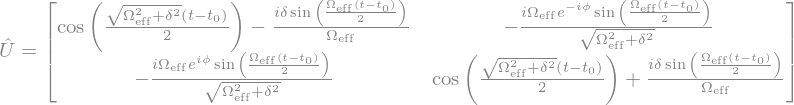

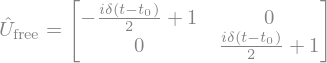

pi- Pulse:


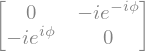

pi/2- Pulse:


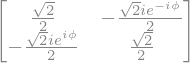

In [4]:
omega_eff = sp.Symbol('\Omega_\mathrm{eff}', real=True, positive=True)

def U(t, t0, phi, delta=0):
    i = sp.I
    omega_R = sqrt(omega_eff**2 + delta**2)
    C = cos(omega_R*(t-t0)/2) + i*(delta/omega_eff)*sin(omega_eff*(t-t0)/2)
    S = exp(i*phi)*omega_eff/omega_R*sin(omega_eff*(t-t0)/2)
    return Matrix(([C.conjugate(), -i*S.conjugate()],[-i*S, C]))


t = sp.Symbol('t', real=True, positive=True)
t0 = sp.Symbol('t_0', real=True, positive=True)
phi = sp.Symbol('\phi', real=True, positive=True)
delta = sp.Symbol('\delta', real=True, positive=True)
display(Eq(Symbol("\hat{U}"),U(t, t0, phi, delta), evaluate=False))

def U_free(t, t0=0, delta=0):
    I = Matrix(([1,0],[0,1]))
    sigma_z = Matrix(([1,0],[0,-1]))
    return I - sp.I*delta/2*(t-t0)*sigma_z

display(Eq(Symbol("\hat{U}_\mathrm{free}"),U_free(t, t0, delta), evaluate=False))

tau = sp.Symbol(r'\tau', real=True, positive=True)

print("pi- Pulse:")
display(U(tau, 0, phi).subs(omega_eff, pi/tau))
print("pi/2- Pulse:")
display(U(tau/2, 0, phi).subs(omega_eff, pi/tau))



# $\text{4-Pulse inteferometer with:} $ $\Omega_R \tau = \pi$

In [5]:
# Symbols used for displaying the equations
P = sp.Symbol('P')
g = sp.Symbol(r'g_\varphi (t)')

# Departure state
psi_i = Matrix([0,1])
# Finale state
psi_f = Matrix([0,1]).transpose()

# Small change of the phase at a time t
dphi = sp.Symbol(r"\delta\varphi",real=True)

def phi_i(n):
    """ Returns a labeled phase symbol"""
    return sp.Symbol(fr"\varphi_{{}}".format(n), real=True)

# Lasers phase at the four pulses
phi_1, phi_2, phi_3, phi_4 = [phi_i(i+1) for i in range(4)]

# Total phase for a 4-pulse interferometer (just to substitute)
phase = sp.Symbol('\Delta\Phi')
phi_tot = phi_1 -2*phi_2+2*phi_3- phi_4


def matrix_product(pulses):
    """ Given a set of evolution matrices, this will do the multiplication"""
    #for i in range(4):
    #    pulses[i] = sp.simplify(pulses[i].subs(omega_eff, pi/tau))
    
    # Use the the pi-pulse condition
    for i in range(4):
        pulses[i] = sp.simplify(pulses[i].subs(omega_eff, pi/tau))
    
    # Matrix product
    evolution = pulses[0]
    for i in range(3):
        evolution *= pulses[i+1]
    return evolution

def probability(evolution, show=True):
    # Given the evolution matrix, calculates the provbaility
    amplitude = (psi_f*evolution*psi_i)[0]
    
    # Simplify with a "DL" (1st order) δφ
    proba = (sp.Abs(amplitude)**2).series(dphi, n=2).removeO().rewrite(sin).simplify().rewrite(sin).simplify()
    
    # Replace 
    proba = proba.subs(phi_tot, phase).subs(tau, pi/omega_eff).simplify()
    if show: display(Eq(P,proba, evaluate=False))
    return proba

def sensitivity_function(proba, show=True):
    """Caculate the sensitivity function at the mid-fringe given the probability function."""
    
    # Probability at mid-fringe
    midfringe = proba.subs(phase, pi/2)
    
    # Derivative of P with respect to δφ
    dP_dPhi = sp.diff(midfringe, dphi).simplify()
    
    # Calculate the limit as d_phi goes to zero
    sens = 2*dP_dPhi.series(dphi, n=1).removeO()
    if show: display(Eq(g,sens, evaluate=False))
    return sens

def interferometer(pulses):
    transfer_matrix = matrix_product(pulses)
    proba = probability(transfer_matrix)
    sens  = sensitivity_function(proba)
    return sens

def perturbated_pulse(duration, phase):
    """ This will create a pulse with a phase perturbation
    which occurs at time t inside of it. """
    pulse = U(duration, t, phase+dphi)*U(t, 0, phase)
    # Taylor Series for d_phi (order 1)
    pulse = pulse.applyfunc(lambda i: i.series(dphi, n=2).removeO().simplify())
    return pulse


### Easy case (Between pulses)

Between pulse 1 and pulse 2:


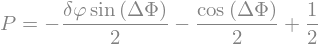

------------------------------------------------------------------
Between pulse 2 and pulse 3:


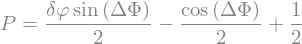

------------------------------------------------------------------
Between pulse 3 and pulse 4:


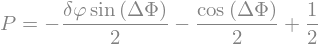

------------------------------------------------------------------


In [6]:

print("Between pulse 1 and pulse 2:")
pulses = [U(tau/2, 0, phi_4+dphi), U(tau, 0, phi_3+dphi), U(tau, 0, phi_2+dphi), U(tau/2, 0, phi_1)]
interferometer(pulses)
print("------------------------------------------------------------------")

print("Between pulse 2 and pulse 3:")
pulses = [U(tau/2, 0, phi_4+dphi), U(tau, 0, phi_3+dphi), U(tau, 0, phi_2), U(tau/2, 0, phi_1)]
interferometer(pulses)
print("------------------------------------------------------------------")

print("Between pulse 3 and pulse 4:")
pulses = [U(tau/2, 0, phi_4+dphi), U(tau, 0, phi_3), U(tau, 0, phi_2), U(tau/2, 0, phi_1)]
interferometer(pulses)
print("------------------------------------------------------------------")



### Inside pulses

Inside Pulse 1:


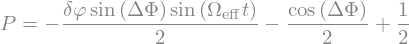

------------------------------------------------------------------
Inside Pulse 2:


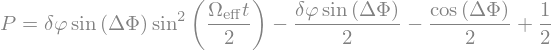

------------------------------------------------------------------
Inside Pulse 3:


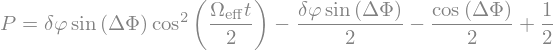

------------------------------------------------------------------
Inside Pulse 4:


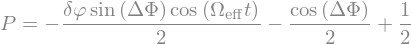

------------------------------------------------------------------


In [8]:
print("Inside Pulse 1:")
pulses = [U(tau/2, 0, phi_4+dphi), U(tau, 0, phi_3+dphi), U(tau, 0, phi_2+dphi), perturbated_pulse(tau/2, phi_1)]
interferometer(pulses)
print("------------------------------------------------------------------")

print("Inside Pulse 2:")
pulses = [U(tau/2, 0, phi_4+dphi), U(tau, 0, phi_3+dphi),perturbated_pulse(tau, phi_2),  U(tau/2, 0, phi_1)]
interferometer(pulses)
print("------------------------------------------------------------------")

print("Inside Pulse 3:")
pulses = [U(tau/2, 0, phi_4+dphi), perturbated_pulse(tau, phi_3), U(tau, 0, phi_2), U(tau/2, 0, phi_1)]
interferometer(pulses)
print("------------------------------------------------------------------")

print("Inside Pulse 4:")
pulses = [perturbated_pulse(tau/2, phi_4), U(tau, 0, phi_3) , U(tau, 0, phi_2), U(tau/2, 0, phi_1)]
interferometer(pulses)
print("------------------------------------------------------------------")
